In [11]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
sns.set_theme(style='darkgrid')

In [12]:
pd.set_option("display.max_columns", None)

In [13]:
from data import get_data
from helpers import pred_to_perf

In [55]:
data = pd.read_excel('data/data.xlsx', index_col=0, skiprows=[0, 1, 2, 3, 4, 5, 6, 8])
data.head()
data.to_csv('data/data.csv')

In [15]:
target_prices = data[['SMALL', 'LARGE']].fillna('ffill').shift(1).dropna()
bench_price = data['SPI'].fillna('ffill').shift(1).dropna()
features = data[data.columns[1:]].fillna('ffill').shift(1).dropna()

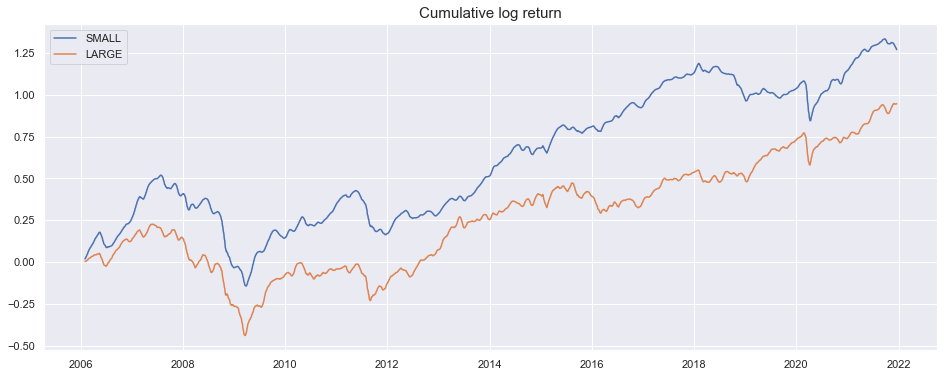

In [16]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = np.log((target_prices.pct_change() + 1).cumprod().rolling(20).mean())
sns.lineplot(data=data_plot, dashes=False)
plt.title('Cumulative log return', fontsize=15)
plt.show()

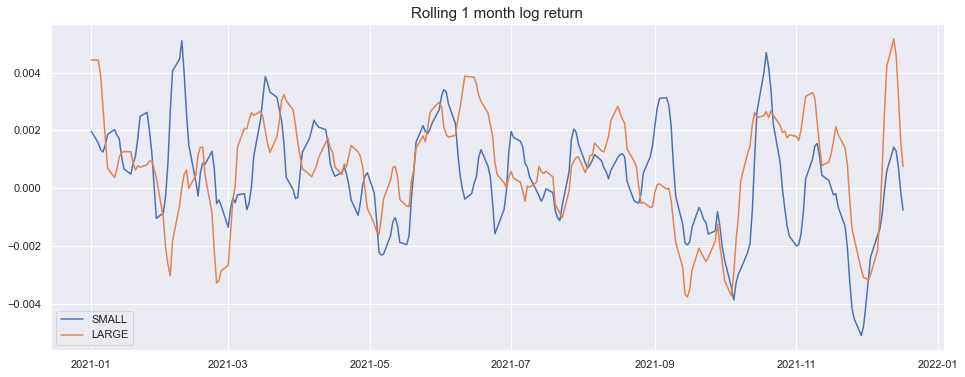

In [17]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0])/ len(x)).rolling(5).mean()
sns.lineplot(data=data_plot.loc['2021-01-01':], dashes=False)
plt.title('Rolling 1 month log return', fontsize=15)
plt.show()

In [18]:
data_stats = data[data.columns[:4]]
data_annual_ret = data_stats.pct_change().mean() * 252 * 100
data_annual_std = data_stats.pct_change().std() * np.sqrt(252) * 100
data_annual_sharpe = data_annual_ret.div(data_annual_std)
data_stats = pd.concat([data_annual_ret, data_annual_std, data_annual_sharpe], axis=1)
data_stats.columns = ['Annualized average return', 'Annualized Std', 'Sharpe Ratio']
data_stats.round(2)

,Annualized average return,Annualized Std,Sharpe Ratio
SPI,7.50,16.51,0.45
SMALL,8.18,10.19,0.80
MID,9.35,15.82,0.59
LARGE,7.34,17.18,0.43


In [19]:
weekly_returns = target_prices.resample('W-FRI').apply(lambda x: np.log(x[-1] / x[0]) / len(x))
best_pred = weekly_returns.rank(axis=1).replace({1: 0., 2: 1.}).shift(-1)

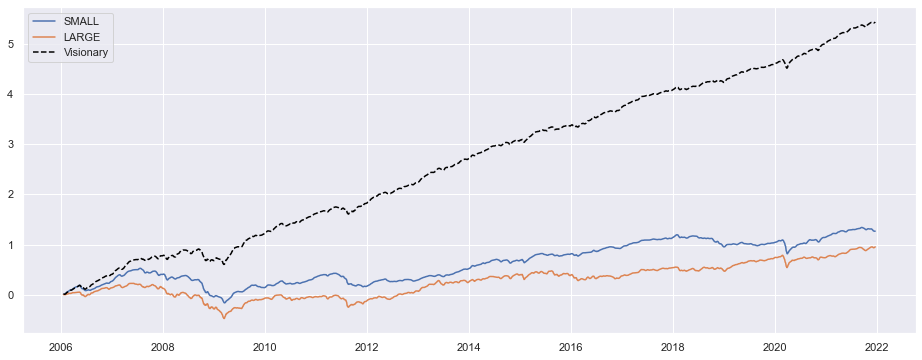

In [20]:
daily_returns = target_prices.pct_change()

fig, ax = plt.subplots(figsize=(16,6))
best_perf = np.log(pred_to_perf(best_pred, daily_returns=daily_returns).rolling(10).mean())
data_plot = np.log((target_prices.pct_change() + 1).reindex(best_perf.index).cumprod().rolling(10).mean())
sns.lineplot(data=data_plot, dashes=False)
sns.lineplot(data=best_perf, color='black', linestyle='--', label='Visionary')
plt.legend()
plt.show()

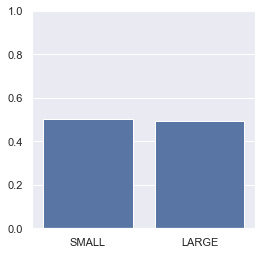

In [25]:
L = len(best_pred)
df_results = (best_pred.sum(axis=0) / L).rename('Best_prediction')
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.ylim(0, 1)
plt.show()

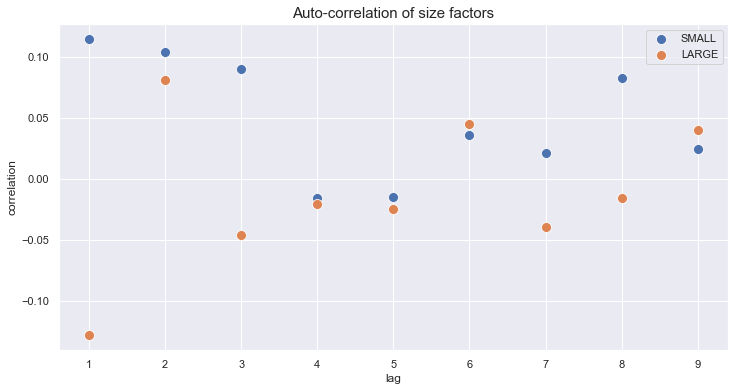

In [30]:
week_input_period = 10
auto_corr = {}
fig, ax = plt.subplots(figsize=(12, 6))
for size in weekly_returns.columns:
    auto_corr[size] = []
    for l in range(1, week_input_period):
        auto_corr[size].append(weekly_returns[size].corr(weekly_returns[size].shift(-l)))
    sns.scatterplot(x=range(1, week_input_period), y=auto_corr[size], label=size, s=100)
plt.xticks(range(1, week_input_period))
plt.title('Auto-correlation of size factors', fontsize=15)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

In [33]:
def fast_fracdiff(x, d):
    import pylab as pl
    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])

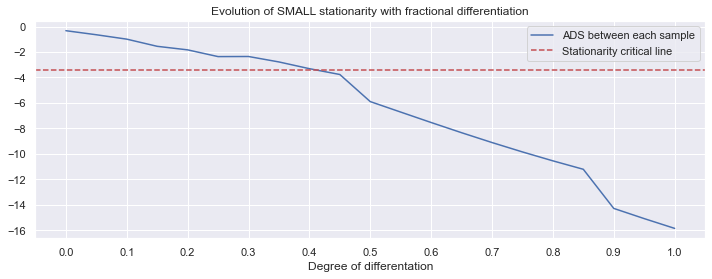

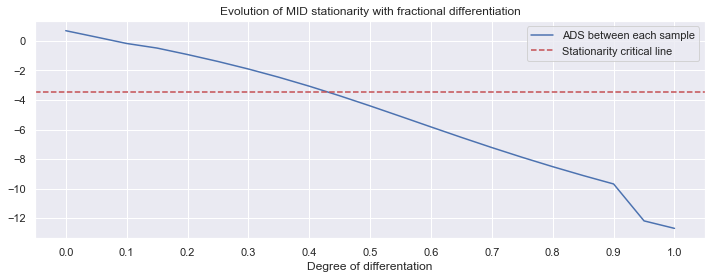

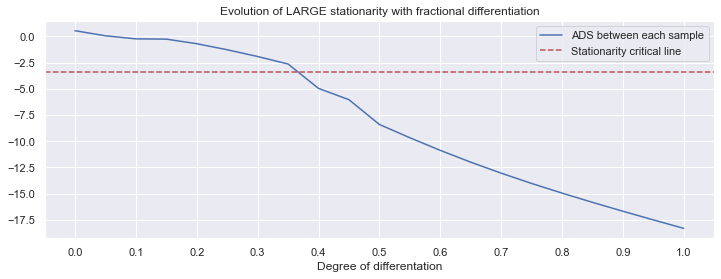

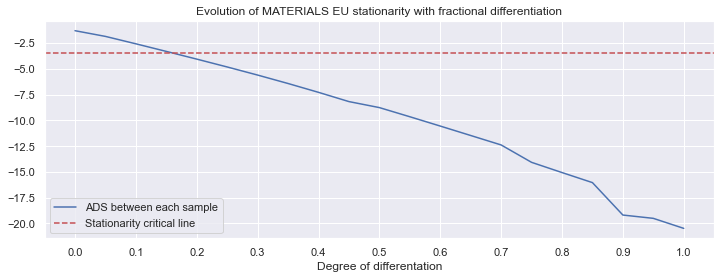

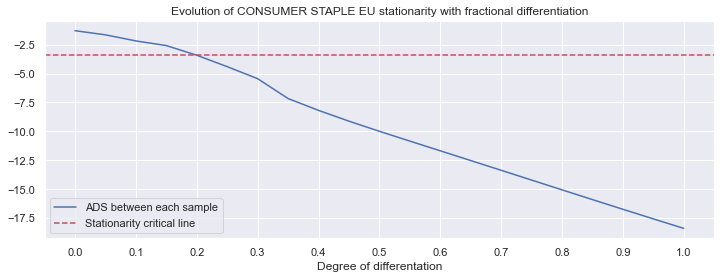

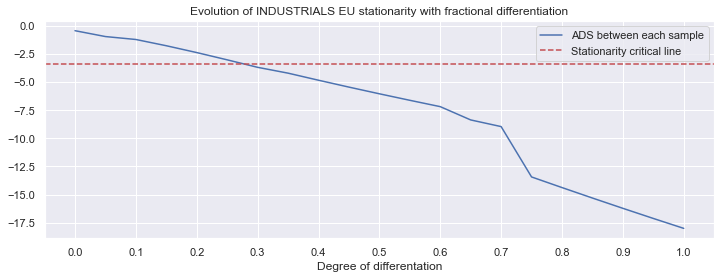

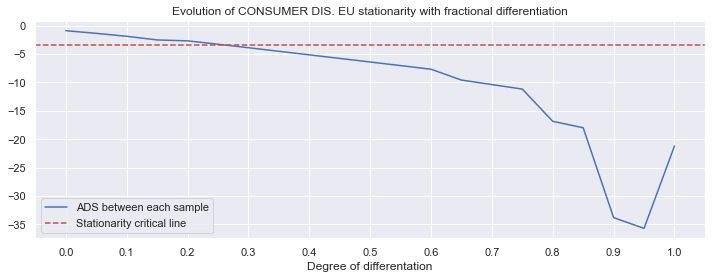

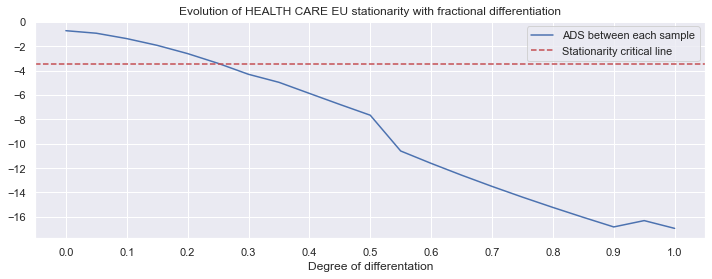

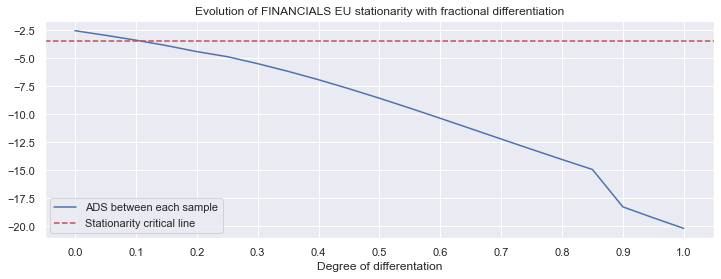

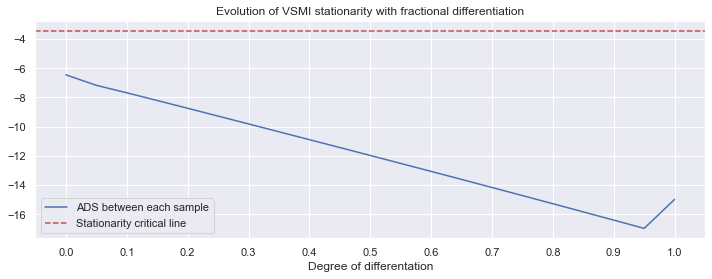

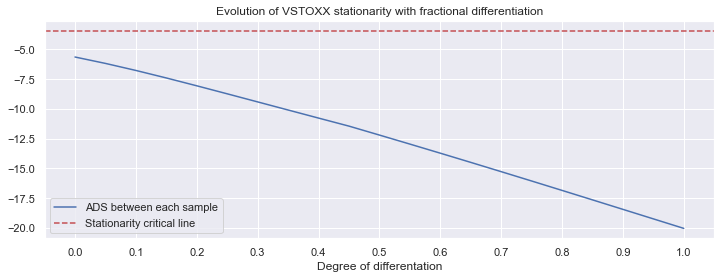

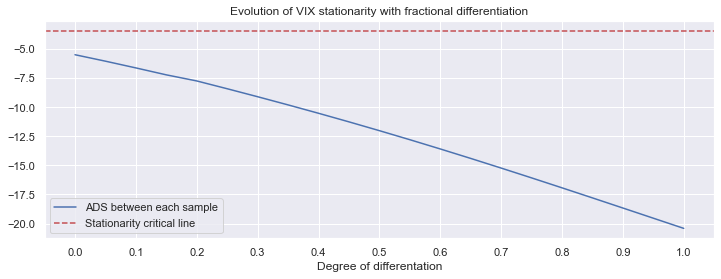

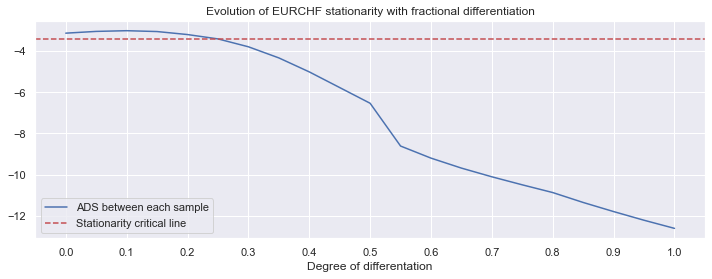

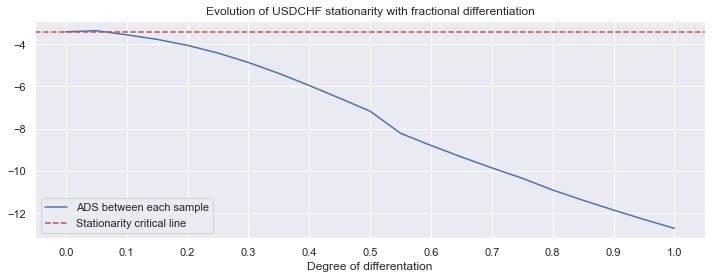

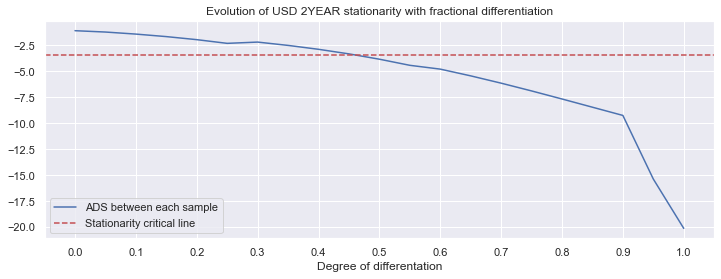

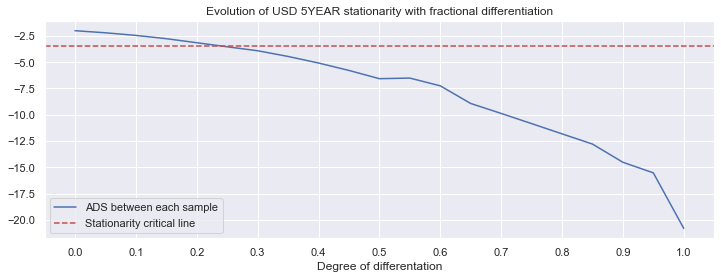

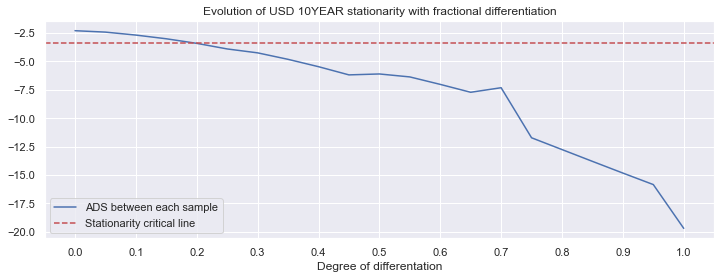

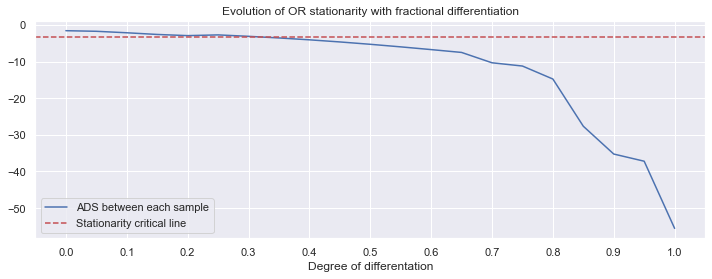

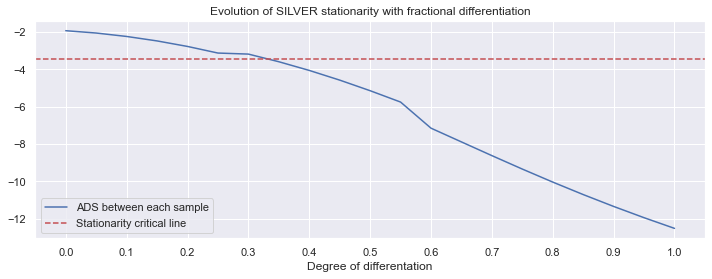

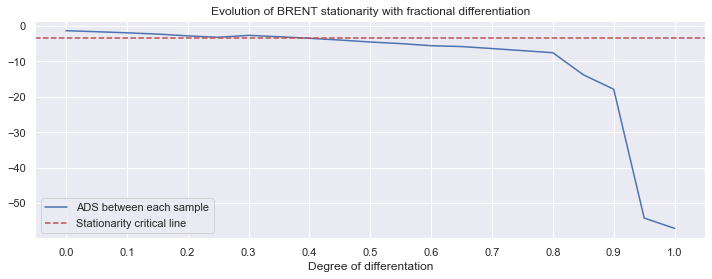

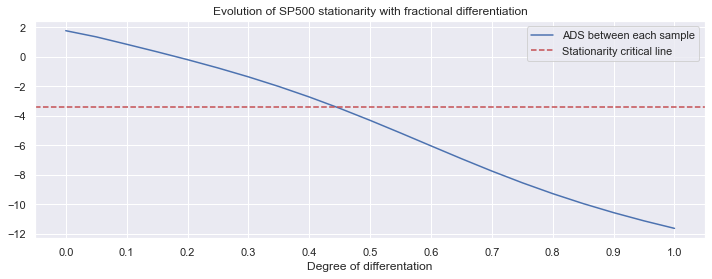

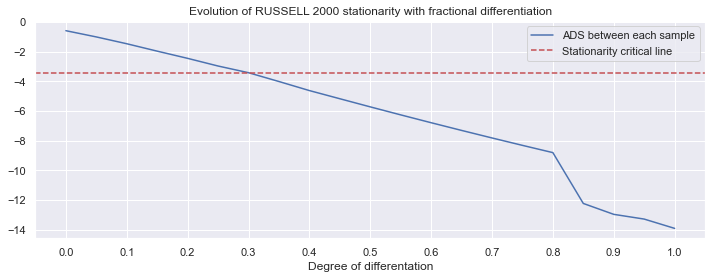

In [109]:
input_period = 21

for feature in features:
    ads_mean_input = []
    d_list = np.linspace(0, 1, 21)
    for d in d_list:
        feature_fdf = pd.Series(fast_fracdiff(features[feature], d), index=features.index)
        ads_between_samples = adfuller(feature_fdf.loc['2010-01-01':])[0]
        ads_mean_input.append(ads_between_samples)
        
    fig, ax = plt.subplots(figsize=(12, 4))
    plt.plot(d_list, ads_mean_input, label='ADS between each sample')
    plt.title(f'Evolution of {feature} stationarity with fractional differentiation')
    plt.axhline(y=-3.43, color='r', linestyle='--', label='Stationarity critical line')
    ax.locator_params(nbins=20, axis='x')
    plt.xlabel('Degree of differentation')
    plt.legend()
    plt.show()

In [111]:
features_stationary = pd.DataFrame().reindex_like(features)
d_list = [0.5, 0.5, 0.4, 0.2, 0.2, 0.3, 0.3, 0.3, 0.2, 0., 0., 0., 0.3, 0.1, 0.5, 0.3, 0.3, 0.3, 0.4, 0.4, 0.5, 0.4]
if len(d_list) != len(features.columns):
    print(f'Error: d_list should have length {len(features.columns)} and has length {len(d_list)}')

for feature, d in zip(features.columns, d_list):
    features_stationary[feature] = fast_fracdiff(features[feature], d)

In [112]:
daily_forward_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).shift(-5)
features_log_returns = features.rolling(input_period).apply(lambda x: np.log(x[-1] / x[0]) / len(x))

df_features_corr = pd.DataFrame(index=target_prices.columns)
df_features_corr_pct = pd.DataFrame(index=target_prices.columns)

for col in features.columns:
    df_features_corr[col] = daily_forward_weekly_returns.corrwith(features_stationary[col])
    df_features_corr_pct[col] = daily_forward_weekly_returns.corrwith(features_log_returns[col])
display(df_features_corr.round(4) * 100)
display(df_features_corr_pct.round(4) * 100)

,SMALL,MID,LARGE,MATERIALS EU,CONSUMER STAPLE EU,INDUSTRIALS EU,CONSUMER DIS. EU,HEALTH CARE EU,FINANCIALS EU,VSMI,VSTOXX,VIX,EURCHF,USDCHF,USD 2YEAR,USD 5YEAR,USD 10YEAR,OR,SILVER,BRENT,SP500,RUSSELL 2000
SMALL,9.60,11.28,8.79,5.51,5.44,8.75,10.20,6.06,6.27,-6.47,-5.69,-7.22,3.23,2.89,8.39,5.16,4.17,-1.96,0.33,2.28,7.40,8.09
LARGE,-4.33,-3.05,-4.25,-4.67,-1.69,-3.99,-1.61,-3.44,-3.19,2.79,4.55,3.67,-1.86,-2.21,1.45,-1.32,-2.63,-0.46,-4.17,-2.18,-3.23,-3.17


,SMALL,MID,LARGE,MATERIALS EU,CONSUMER STAPLE EU,INDUSTRIALS EU,CONSUMER DIS. EU,HEALTH CARE EU,FINANCIALS EU,VSMI,VSTOXX,VIX,EURCHF,USDCHF,USD 2YEAR,USD 5YEAR,USD 10YEAR,OR,SILVER,BRENT,SP500,RUSSELL 2000
SMALL,11.80,13.34,11.61,14.42,7.89,12.71,12.52,2.55,12.61,-9.90,-11.24,-10.88,2.62,-2.11,6.00,7.74,8.92,-9.47,-0.59,5.50,10.55,10.74
LARGE,-6.84,-5.85,-6.23,-5.71,-6.53,-6.87,-4.76,-9.58,-4.65,3.08,3.43,3.37,-0.69,-2.35,-3.85,-3.78,-3.79,-6.48,-7.20,-3.31,-7.06,-7.05


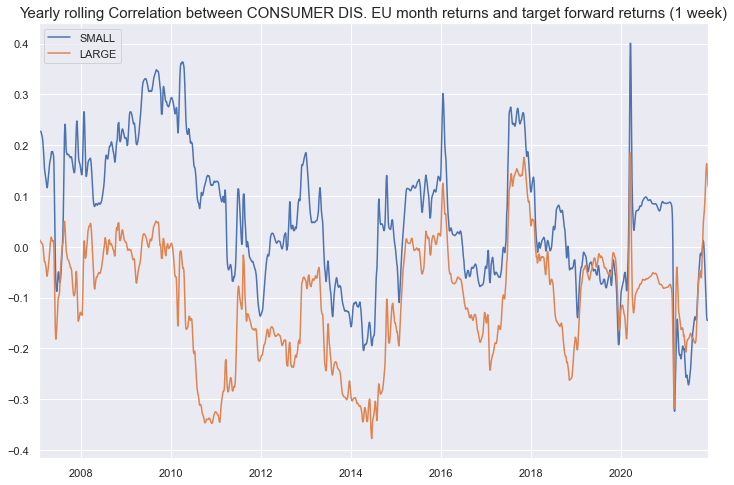

In [113]:
fig, ax = plt.subplots(figsize=(12, 8))
feature = 'CONSUMER DIS. EU'
daily_forward_weekly_returns.rolling(252).corr(features_log_returns[feature]).dropna().rolling(10).mean().plot(ax=ax)
plt.title(f'Yearly rolling Correlation between {feature} month returns and target forward returns (1 week)', fontsize=15)
plt.show()

In [114]:
df_features_stat = pd.DataFrame(index=target_prices.columns)
for feature in features_log_returns:
    for target in daily_forward_weekly_returns:
        endog = daily_forward_weekly_returns[target].iloc[input_period:-input_period]
        exog = features_log_returns[feature].iloc[input_period:-input_period]
        model = sm.OLS(endog, exog, missing='raise')
        results = model.fit()
        
        df_features_stat.at[target, feature] = results.pvalues.values
df_features_stat[df_features_stat < 0.05].round(4)

,SMALL,MID,LARGE,MATERIALS EU,CONSUMER STAPLE EU,INDUSTRIALS EU,CONSUMER DIS. EU,HEALTH CARE EU,FINANCIALS EU,VSMI,VSTOXX,VIX,EURCHF,USDCHF,USD 2YEAR,USD 5YEAR,USD 10YEAR,OR,SILVER,BRENT,SP500,RUSSELL 2000
SMALL,0.0000,0.000,0.0000,0.0000,0.0000,0.0,0.0000,0.0314,0.0000,0.0,0.0000,0.0000,NaN,NaN,0.0002,0.000,0.0000,0.0000,NaN,0.0004,0.0000,0.0
LARGE,0.0001,0.001,0.0003,0.0004,0.0002,0.0,0.0062,0.0000,0.0026,NaN,0.0396,0.0434,NaN,NaN,0.0080,0.012,0.0125,0.0002,0.0,0.0452,0.0001,0.0


df_ads = pd.DataFrame(index=['ADS within each sample', 'ADS between each sample'])

rolling_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).dropna()

ads_input = {}
ads_mean_input = {}
input_periods = range(10, 42, 1)

for feature in log_weekly_returns:
    feature_fdf = log_weekly_returns[target].loc['2010-01-01':]
    feature_fdf_normalized = (feature_fdf - feature_fdf.mean()) / feature_fdf.std()
    
    ads_input[feature] = []
    ads_mean_input[feature] = []
    for input_period in input_periods:
        ads_input[feature].append(feature_fdf_normalized.rolling(input_period).apply(lambda x: adfuller(x)[0]).mean())
        ads_mean_input[feature].append(adfuller(feature_fdf_normalized.rolling(input_period).mean().dropna())[0])

fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
for i, feature in enumerate(log_weekly_returns):
    sns.lineplot(ax=axs[i], x=input_periods, y=ads_input[feature], label='Average ADS within each sample', dashes=False)
    sns.lineplot(ax=axs[i], x=input_periods, y=ads_mean_input[feature], label='ADS between each sample', dashes=False)
    axs[i].set_title(feature)
plt.xlabel('time serie length of a sample (lookback period)')
plt.suptitle('Weekly log returns stationarity within and between samples')
plt.show()

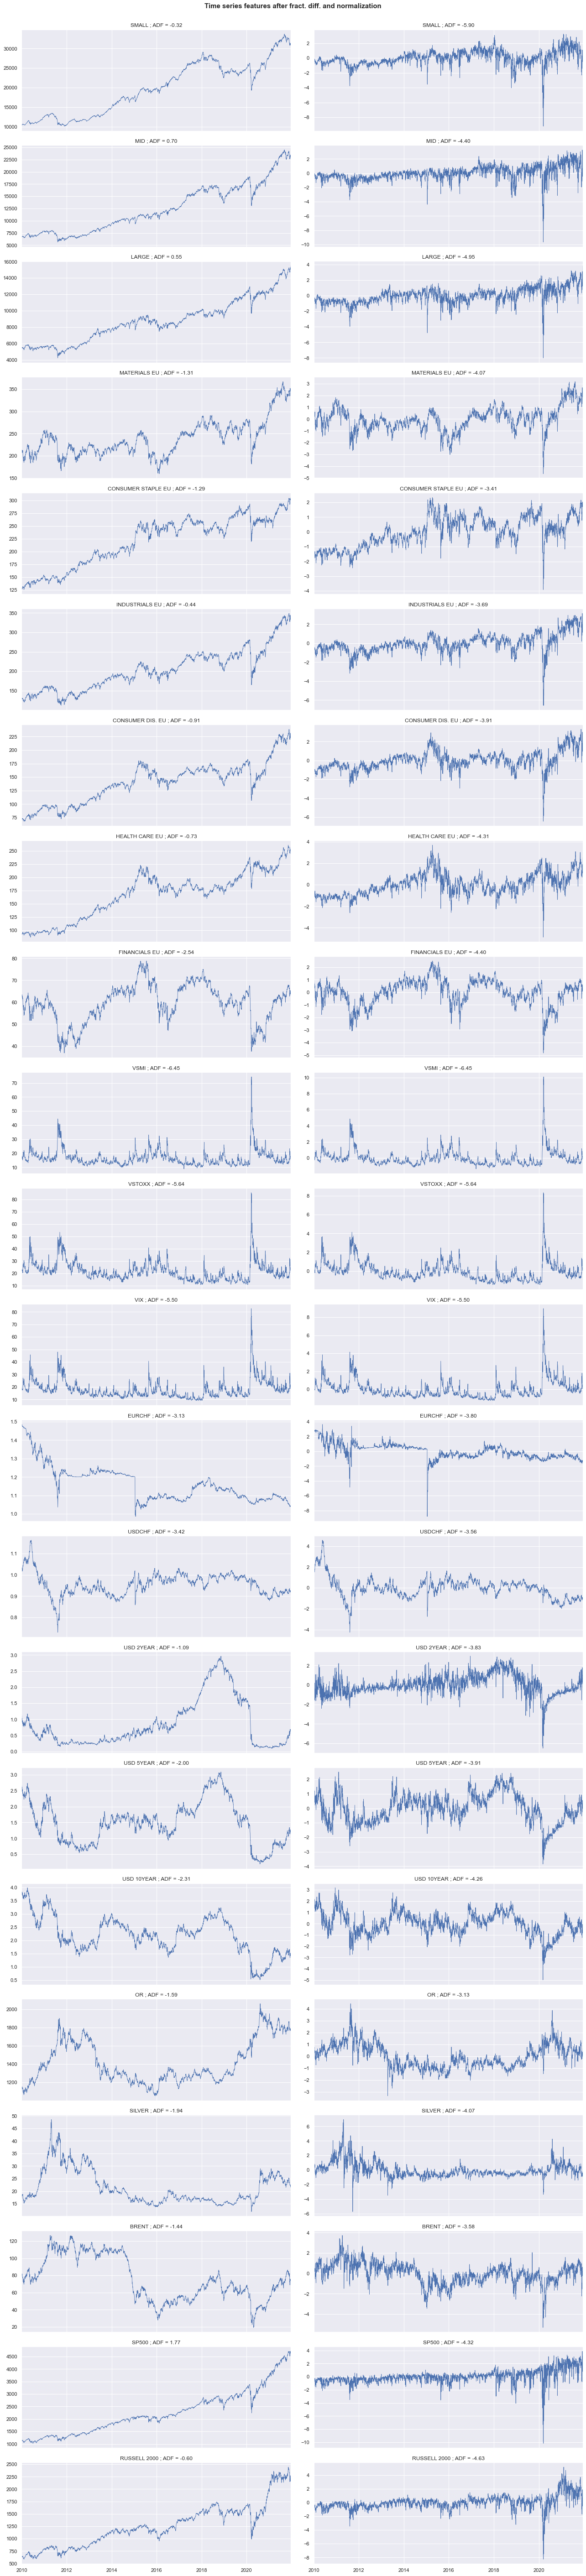

In [115]:
data_plot = features.loc['2010-01-01':]

data_plot_stat = features_stationary.loc['2010-01-01':]
data_plot_stat = (data_plot_stat - data_plot_stat.mean()) / data_plot_stat.std()
#data_plot_stat = (data_plot_stat - data_plot_stat.min()) / (data_plot_stat.max() - data_plot_stat.min())

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(number_feature, 2, figsize=(18, 80), sharex=True)

for i, col in enumerate(data_plot.columns):
    
    ads = adfuller(data_plot[col].values)[0]
    data_plot[col].plot(ax=axs[i, 0], lw=0.8)
    axs[i, 0].set_title(col + f' ; ADF = {ads:.2f}')
    
    ads_stat = adfuller(data_plot_stat[col].values)[0]
    data_plot_stat[col].plot(ax=axs[i, 1], lw=0.8)
    axs[i, 1].set_title(col + f' ; ADF = {ads_stat:.2f}')
    
plt.suptitle('Time series features after fract. diff. and normalization', fontsize=15, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.97)
plt.show()

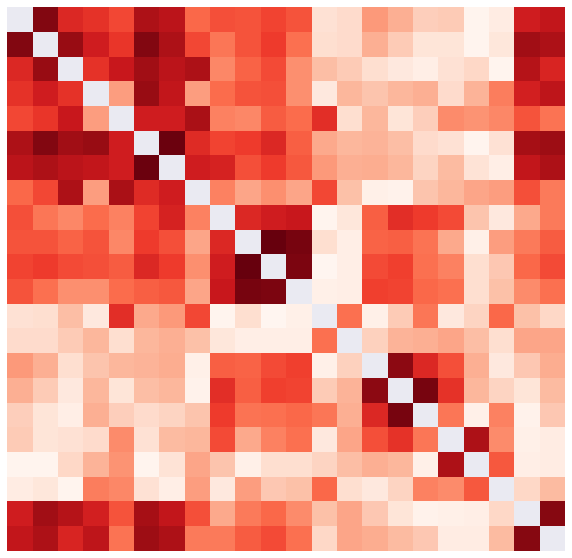

In [116]:
corr = data_plot_stat.corr().abs().round(2)

fig, ax = plt.subplots(figsize=(10,10))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=False, cmap='Reds', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=8, labelbottom=False, labeltop=False, labelleft=False, length=0)
plt.show()